#load data and image folder

In [ ]:
from google.colab.drive import mount
mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/colab/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c hackathon-online-phuket-landmark-recognition

 98% 797M/815M [00:05<00:00, 196MB/s]
100% 815M/815M [00:05<00:00, 148MB/s]


In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-b33hr9in
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-b33hr9in
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 9ee846ff0cbbc05a99b45140aa6d84083bcf6488
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.0 MB/s eta 0:00:00
  Created wheel for timm: filename=timm-0.8.20.dev0-py3-none-any.whl size=2169431 sha256=23e03266426efb849336502209756b22a8edbb280c305107c19b20fb10e11295
  Stored in directory: /tmp/pip-ephem-wheel-cache-yk90m3ae/wheels/eb/1e/79/4dfc1bba276172378ab3e51ceed8e

In [ ]:
import timm
from fastai import *
from fastai.vision.all import *

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
from tqdm import notebook as tqdm
import numpy as np
import pandas as pd
import pandas as pd
import cv2
import PIL
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
import multiprocessing
from multiprocessing.pool import ThreadPool
from google.colab.patches import cv2_imshow

In [ ]:
!unzip /content/hackathon-online-phuket-landmark-recognition.zip

Archive:  /content/hackathon-online-phuket-landmark-recognition.zip
  inflating: images/images/test/0004fcda10aa2377d890889589ae0d97.jpg  
  inflating: images/images/test/004edc755680abbde98e6f41aee97f69.jpg  
  inflating: images/images/test/004fb09c10a6f7d1edd2d3704bd57b96.jpg  
  inflating: images/images/test/006e4d030af75483a051695252d08206.jpg  
  inflating: images/images/test/007d51841b2fe6620aa8f0de8ec6172d.jpg  
  inflating: images/images/test/00cb84d245b35cdc5c98afd2f8aafdd7.jpg  
  inflating: images/images/test/00d05e75e899f7e24832c361e882f307.jpg  
  inflating: images/images/test/00eaca4b9c17a91b4511ec370dab3d95.jpg  
  inflating: images/images/test/00fb8be7c7fe994160f864bcb55fed4c.jpg  
  inflating: images/images/test/015c87ba424f248e00d220e802c10b3f.jpg  
  inflating: images/images/test/01b43c79038adc621bc717e4b5f22056.jpg  
  inflating: images/images/test/01b4f3ac314a808e7d582b1135b65973.jpg  
  inflating: images/images/test/01bbc26b5004a370fee99d7bf2ee14dd.jpg  
  inflati

In [ ]:
train_df=pd.read_csv("/content/train.csv")
train_df

,id,label
0,dc8ca8843cc05c937ae4086da5ad49f1.jpg,7
1,abf428c748961ce38012c04fb4f67a0a.jpg,10
2,7bef6daf30000b2bb9e57af7bc87b780.jpg,1
3,db6f12a84dedc23e3d55320a9149d69a.jpg,7
4,8d17fcf554881b42a070162c19f73f3a.jpg,8
...,...,...
2720,50db1fe1991abf6aaf36f6f4f1b66cd4.jpg,3
2721,c0cdb5a4aa8060e763bcaae3cd7cc702.jpg,14
2722,c953c76faa7580b3b00be8856f6e9d98.jpg,8
2723,174cae6121652e3527460e8f52672875.jpg,4


In [ ]:
train_df["label"].unique()

array([ 7, 10,  1,  8, 13, 11,  9,  4,  6,  5,  0,  2, 12, 14,  3])

<Axes: xlabel='label', ylabel='count'>

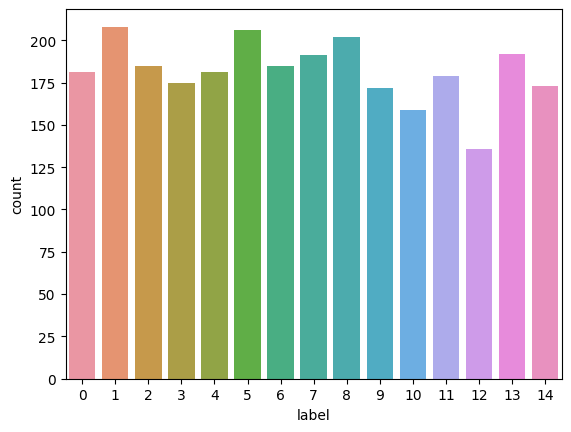

In [ ]:
sns.countplot(x=train_df["label"])

In [ ]:
submit=pd.read_csv("/content/submit.csv")
submit

,id,predict
0,6a270f855c45a53c9cd29704e4ec1811.jpg,3.0
1,2c76f54dd40ef6747cc2e179c091173c.jpg,1.0
2,8a2ab1e2da3aa24c838d2644b8beca77.jpg,7.0
3,5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg,NaN
4,6cea6f1ff4873fbcaa4e2ec4e082e361.jpg,NaN
...,...,...
745,5bce0705ef5f0faac903c2faf9c53aca.jpg,NaN
746,4c8be14290024ffdce888f29005b060c.jpg,NaN
747,3e827c4af3529528da4a1edaccbc8b7a.jpg,NaN
748,6f894e140ac980a105dfaa3078389711.jpg,NaN


In [ ]:
test_df=pd.read_csv("/content/test.csv")
test_df

,id
0,6a270f855c45a53c9cd29704e4ec1811.jpg
1,2c76f54dd40ef6747cc2e179c091173c.jpg
2,8a2ab1e2da3aa24c838d2644b8beca77.jpg
3,5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg
4,6cea6f1ff4873fbcaa4e2ec4e082e361.jpg
...,...
745,5bce0705ef5f0faac903c2faf9c53aca.jpg
746,4c8be14290024ffdce888f29005b060c.jpg
747,3e827c4af3529528da4a1edaccbc8b7a.jpg
748,6f894e140ac980a105dfaa3078389711.jpg


In [ ]:
(submit["id"]==test_df["id"]).sum()

750

In [ ]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [ ]:
def auto_contrast(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf_normalized, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    min_intensity = np.argmin(cdf)
    max_intensity = np.argmax(cdf)
    scale_factor = 255.0 / (max_intensity - min_intensity)
    img = (img - min_intensity) * scale_factor
    img = np.clip(img, 0, 255)
    return img.astype('uint8')

from albumentations import ImageOnlyTransform

class AutoContrast(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)

    def apply(self, img, **params):
        return auto_contrast(img)
        
    def get_transform_init_args_names(self):
        return ()

In [ ]:
image_size =448
def get_train_aug(): return A.Compose([
            #AutoContrast(),
            #A.PadIfNeeded(always_apply=False, p=1.0, min_height=448, min_width=448, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            #A.HorizontalFlip(p=0.2),
            #A.ImageCompression(quality_lower=99, quality_upper=100),
            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
            #A.Sharpen(always_apply=True, p=1.0, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            #A.HueSaturationValue(
                #hue_shift_limit=0.3, 
               # sat_shift_limit=0.3, 
              #  val_shift_limit=0.3, 
             #   p=0.5
            #),
            #A.RandomBrightnessContrast(p=0.2),
            A.Resize(image_size, image_size),
            #A.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
            #albumentations.ColorJitter(contrast=(0.9, 1.1)),
            #albumentations.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
            #albumentations.RandomGamma(),
            #albumentations.ToGray(always_apply=False, p=1.0)
            
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.)
def get_valid_aug(): return A.Compose([
            A.Resize(always_apply=False, p=1.0, height=image_size, width=image_size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            #albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),
             
            ], p=1.0)

In [ ]:
def add_dir(x):
  return "/content/images/images/train/"+x

In [ ]:
train_df["id"]=train_df["id"].apply(lambda x:add_dir(x))

In [ ]:
"""for idx,row in train_df[train_df['label']==1].iterrows():
  img = cv2.imread(row["id"])
  img=cv2.resize(img,(448,448))
  cv2_imshow(img)"""

In [ ]:
item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [ ]:
blocks = (ImageBlock, CategoryBlock)
splitter = TrainTestSplitter(0.01, stratify=train_df["label"],shuffle=True)
block = DataBlock(blocks = blocks,
                 get_x=ColReader(0),
                 get_y=ColReader(1),
                 splitter = splitter,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms)

dls = block.dataloaders(train_df, bs=8)

#model

In [ ]:
#set seed
np.random.seed(114)
torch.manual_seed(114) 
random.seed(114)

In [ ]:
timm.list_models('*eva02*',pretrained=False)#timm.list_models('*eva02*',pretrained=True)

['eva02_base_patch14_224.mim_in22k',
 'eva02_base_patch14_448.mim_in22k_ft_in1k',
 'eva02_base_patch14_448.mim_in22k_ft_in22k',
 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k',
 'eva02_base_patch16_clip_224.merged2b',
 'eva02_enormous_patch14_clip_224.laion2b',
 'eva02_enormous_patch14_clip_224.laion2b_plus',
 'eva02_large_patch14_224.mim_in22k',
 'eva02_large_patch14_224.mim_m38m',
 'eva02_large_patch14_448.mim_in22k_ft_in1k',
 'eva02_large_patch14_448.mim_in22k_ft_in22k',
 'eva02_large_patch14_448.mim_in22k_ft_in22k_in1k',
 'eva02_large_patch14_448.mim_m38m_ft_in1k',
 'eva02_large_patch14_448.mim_m38m_ft_in22k',
 'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k',
 'eva02_large_patch14_clip_224.merged2b',
 'eva02_large_patch14_clip_336.merged2b',
 'eva02_small_patch14_224.mim_in22k',
 'eva02_small_patch14_336.mim_in22k_ft_in1k',
 'eva02_tiny_patch14_224.mim_in22k',
 'eva02_tiny_patch14_336.mim_in22k_ft_in1k']

In [ ]:
early_stop= EarlyStoppingCallback(monitor='train_loss',patience=1)
callbacks = [
    early_stop,ShowGraphCallback()]

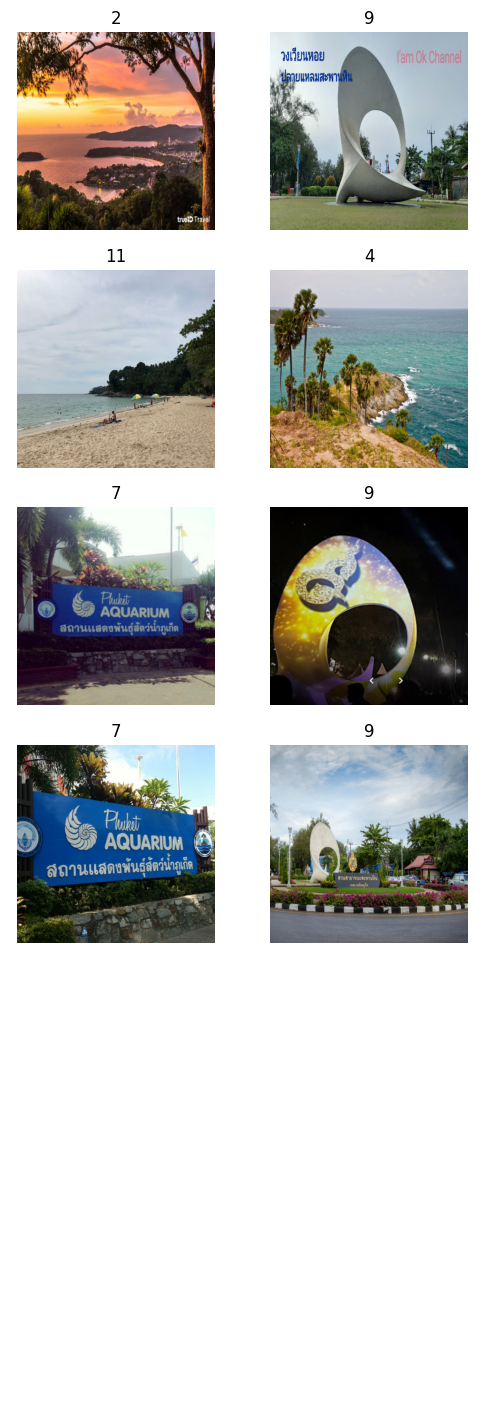

In [ ]:
dls.show_batch(max_n=11,nrows=6,)

In [ ]:
learner = vision_learner(dls,
                       'eva02_large_patch14_448',
                       loss_func=nn.CrossEntropyLoss(),
                       metrics=[accuracy],
                       )

#eva02_large_448

In [ ]:
learner.to_fp16()

epoch,train_loss,valid_loss,accuracy,time
0,1.070606,0.549382,0.857143,02:18


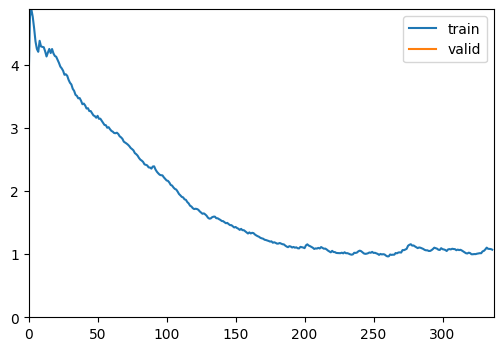

epoch,train_loss,valid_loss,accuracy,time
0,0.515496,0.270509,0.928571,02:53
1,0.449975,0.511011,0.892857,02:53
2,0.348350,0.198165,0.892857,02:53
3,0.241704,0.312924,0.964286,02:53
4,0.180305,0.345450,0.964286,02:53
5,0.092362,0.378785,0.892857,02:53
6,0.063879,0.262724,0.964286,02:52
7,0.063079,0.355993,0.964286,02:52
8,0.057055,0.321015,0.964286,02:53
9,0.060312,0.280668,0.964286,02:53


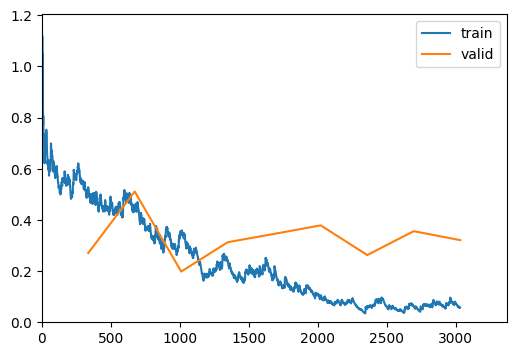

No improvement since epoch 8: early stopping


In [ ]:
learner.fine_tune(10,cbs=callbacks)

In [ ]:
learner.save('/content/maxvit')

Path('/content/eva02.pth')

In [ ]:
learner.load("/content/eva02")

#predict

In [ ]:
submit

In [ ]:
def add_dir_test(x):
  return "/content/images/images/test/"+x

In [ ]:
submit=pd.read_csv("/content/eva02_3.csv")
submit["id"]=submit["id"].apply(lambda x:add_dir_test(x))

In [ ]:
submit

,id,predict
0,/content/images/images/test/6a270f855c45a53c9cd29704e4ec1811.jpg,3
1,/content/images/images/test/2c76f54dd40ef6747cc2e179c091173c.jpg,1
2,/content/images/images/test/8a2ab1e2da3aa24c838d2644b8beca77.jpg,7
3,/content/images/images/test/5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg,13
4,/content/images/images/test/6cea6f1ff4873fbcaa4e2ec4e082e361.jpg,3
...,...,...
745,/content/images/images/test/5bce0705ef5f0faac903c2faf9c53aca.jpg,13
746,/content/images/images/test/4c8be14290024ffdce888f29005b060c.jpg,3
747,/content/images/images/test/3e827c4af3529528da4a1edaccbc8b7a.jpg,7
748,/content/images/images/test/6f894e140ac980a105dfaa3078389711.jpg,12


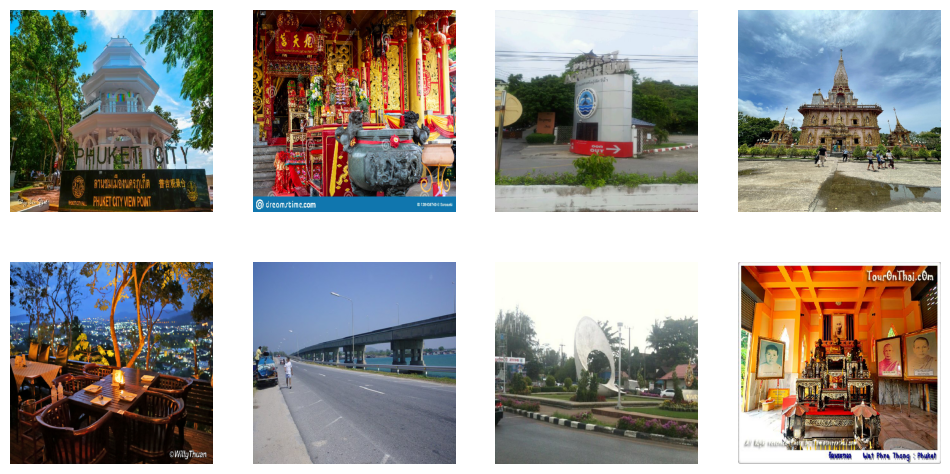

In [ ]:
tst_dl = dls.test_dl(test_df["id"].apply(lambda x:add_dir_test(x)))
tst_dl.show_batch(max_n=8,nrows=2)

In [ ]:
tta = learner.tta(dl=tst_dl, n=64)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should b

In [ ]:
tta

(tensor([[-0.1950,  0.4273, -2.5728,  ..., -0.0980, -0.9384, -0.5481],
         [-5.0264, 13.3730, -2.9009,  ..., -1.7432,  2.0046,  2.4028],
         [-1.5410,  0.5346, -1.1506,  ...,  1.2271, -1.8052, -0.2115],
         ...,
         [-4.6865, -4.4307,  2.5645,  ..., -3.9702, -1.2225, -5.2695],
         [-1.4343, -3.9888, -3.0884,  ..., 19.5547, -3.7998, -4.4775],
         [ 5.7285, -1.1124, -7.8428,  ..., -3.1699, -1.2505, -2.6963]]),
 None)

In [ ]:
#tta = learner.get_preds(dl=tst_dl)
#tta

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(tensor([[-0.3843,  3.3418,  0.9648,  ..., -1.9805, -3.0996, -1.5527],
         [-2.8652, 16.1562, -1.5430,  ..., -1.2354, -0.3010,  1.1074],
         [-2.7051, -2.2754,  1.6016,  ..., -1.5752, -2.2012, -3.4102],
         ...,
         [-1.0332, -0.1635,  2.2363,  ..., -3.0586, -2.4160, -1.8945],
         [-1.1504,  0.7319, -2.7324,  ..., 19.0312,  0.3843, -5.3242],
         [-0.7061, -1.5635, -2.8340,  ..., -1.1104, -2.9375, -0.7729]]),
 None)

In [ ]:
submit[374:380]

,id,predict
374,/content/images/images/test/8c7c03b738d474bf35cb105da255089a.jpg,11
375,/content/images/images/test/7d5758543293c6f9982015c722322a06.jpg,10
376,/content/images/images/test/5b658ddca53554a6c420b0ac89f30a66.jpg,13
377,/content/images/images/test/5e91ca0fcd002d0991bdbb57d888c2a5.jpg,8
378,/content/images/images/test/2cbdbc0e272f04f544f3544b3b8ad299.jpg,12
379,/content/images/images/test/1a8a0b870ff24e0c5f4ae6892dbe1755.jpg,10


In [ ]:
tta_preds, _ = tta
idxs = tta_preds.argmax(dim=1)
submit["predict"]=np.array(idxs)

In [ ]:
submit

,id,predict
0,/content/images/images/test/6a270f855c45a53c9cd29704e4ec1811.jpg,3
1,/content/images/images/test/2c76f54dd40ef6747cc2e179c091173c.jpg,1
2,/content/images/images/test/8a2ab1e2da3aa24c838d2644b8beca77.jpg,7
3,/content/images/images/test/5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg,13
4,/content/images/images/test/6cea6f1ff4873fbcaa4e2ec4e082e361.jpg,3
...,...,...
745,/content/images/images/test/5bce0705ef5f0faac903c2faf9c53aca.jpg,13
746,/content/images/images/test/4c8be14290024ffdce888f29005b060c.jpg,3
747,/content/images/images/test/3e827c4af3529528da4a1edaccbc8b7a.jpg,7
748,/content/images/images/test/6f894e140ac980a105dfaa3078389711.jpg,12


In [ ]:
for idx,rows in submit[submit["predict"]==11].iterrows():
  img=cv2.imread(rows["id"])
  img=cv2.resize(img,(128,128))
  print(idx,rows["predict"])
  cv2_imshow(img)

In [ ]:
submit.to_csv("eva02_2.csv",index=False)